In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
import math
import sqlite3
import zipfile
import warnings
warnings.filterwarnings('ignore')

In [2]:
#movie = pd.read_csv('zippedData/tmdb.movies.csv.gz')
#movie_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz',sep='\t', compression='gzip')
#movie_review = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', encoding='latin1')
#movie_gross = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
movie_budget = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
conn = sqlite3.connect('im.db.zip')
#specify the path to the zip file
zip_file_path = 'zippedData/im.db.zip'

#Extract the SQLite database file from the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('unzippedData')

#connect to extracted SQLite database
database_path = 'unzippedData/im.db'
conn = sqlite3.connect(database_path)

In [4]:
movie_budget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [5]:
# convert "release_date" column to datetime format
movie_budget["release_date"] = pd.to_datetime(movie_budget["release_date"])

# create "year" and "month" columns from "release_date" column
movie_budget["release_year"] = movie_budget["release_date"].dt.year
movie_budget["release_month"] = movie_budget["release_date"].dt.month


In [6]:
# convert "production_budget", "domestic_gross" and "worldwide_gross" columns to int64 format
movie_budget["production_budget"] = movie_budget["production_budget"].str.replace(",", "").str.replace("$", "").astype("int64")
movie_budget["domestic_gross"] = movie_budget["domestic_gross"].str.replace(",", "").str.replace("$", "").astype("int64")
movie_budget["worldwide_gross"] = movie_budget["worldwide_gross"].str.replace(",", "").str.replace("$", "").astype("int64")

#drop columns where worldwide gross is 0, since they were not released theatrically 
movie_budget = movie_budget[movie_budget['worldwide_gross'] != 0]

# create "foreign_gross" column by subtracting "domestic_gross" from "worldwide_gross"
movie_budget["foreign_gross"] = movie_budget["worldwide_gross"] - movie_budget["domestic_gross"]

# create "total_profit" column by subtracting "worldwide_gross" from "production_budget"
movie_budget["total_profit"] = movie_budget["worldwide_gross"] - movie_budget["production_budget"]


In [7]:
movie_basics = pd.read_sql("""
SELECT primary_title, genres
FROM movie_basics
""",conn)

In [11]:
movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136071 entries, 0 to 146143
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   primary_title  136071 non-null  object
 1   genres         130998 non-null  object
dtypes: object(2)
memory usage: 3.1+ MB


In [10]:
movie_basics.drop_duplicates(subset="primary_title", keep="last", inplace=True)

In [12]:
# merge movie_basics and movie_budget on movie and primary_title
movie_df = pd.merge(movie_basics, movie_budget, left_on="primary_title", right_on="movie", how="inner")

In [13]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2153 entries, 0 to 2152
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   primary_title      2153 non-null   object        
 1   genres             2124 non-null   object        
 2   id                 2153 non-null   int64         
 3   release_date       2153 non-null   datetime64[ns]
 4   movie              2153 non-null   object        
 5   production_budget  2153 non-null   int64         
 6   domestic_gross     2153 non-null   int64         
 7   worldwide_gross    2153 non-null   int64         
 8   release_year       2153 non-null   int64         
 9   release_month      2153 non-null   int64         
 10  foreign_gross      2153 non-null   int64         
 11  total_profit       2153 non-null   int64         
dtypes: datetime64[ns](1), int64(8), object(3)
memory usage: 218.7+ KB


In [14]:
movie_df.drop(["primary_title", "id"], axis=1, inplace=True)

In [15]:
m

2015    205
2011    198
2014    190
2013    183
2012    180
       ... 
1959      1
1964      1
1948      1
1956      1
1937      1
Name: release_year, Length: 68, dtype: int64

In [16]:
#drop films before 2010
movie_df = movie_df[movie_df["release_year"] >= 2010]

In [19]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1597 entries, 0 to 2152
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   movie              1597 non-null   object
 1   genres             1587 non-null   object
 2   release_month      1597 non-null   int64 
 3   release_year       1597 non-null   int64 
 4   production_budget  1597 non-null   int64 
 5   domestic_gross     1597 non-null   int64 
 6   foreign_gross      1597 non-null   int64 
 7   worldwide_gross    1597 non-null   int64 
 8   total_profit       1597 non-null   int64 
dtypes: int64(7), object(2)
memory usage: 124.8+ KB


In [18]:
movie_df = movie_df[["movie", "genres", 'release_month', 'release_year', "production_budget", "domestic_gross", "foreign_gross", "worldwide_gross", "total_profit"]]

In [20]:
#create columns for low, mid, and high budgets films 
def budget(x): 
    if x < 5000000: 
        budget = 'low'
    if 5000000 <= x < 50000000: 
        budget = 'mid'
    if x >= 50000000:
        budget = 'high'
    return budget
#feature engineering a new column for budget categories 
movie_df['budget'] = movie_df['production_budget'].apply(lambda x: budget(x))

In [22]:
#drop null genres
movie_df.dropna(subset='genres', inplace=True)

In [23]:
#create main genre column
def get_main_genre(x):
    genres = x.split(',')
    main_genre = genres[0]
    return main_genre
movie_df['main_genre'] = movie_df['genres'].apply(lambda x: get_main_genre(x))

In [24]:
#create subgenres column
def get_subgenres(x):
    genres = x.split(',')
    sub_genres = genres[1:]
    return sub_genres
movie_df['subgenres'] = movie_df['genres'].apply(lambda x: get_subgenres(x))

In [29]:
movie_df = movie_df[["movie", "genres", 'main_genre', 'subgenres', 'release_month', 'release_year', 'budget', "production_budget", "domestic_gross", "foreign_gross", "worldwide_gross", "total_profit"]]

In [26]:
movie_df.reset_index(inplace=True)

In [27]:
movie_df.drop('index', axis =1, inplace=True)

In [30]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1587 entries, 0 to 1586
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   movie              1587 non-null   object
 1   genres             1587 non-null   object
 2   main_genre         1587 non-null   object
 3   subgenres          1587 non-null   object
 4   release_month      1587 non-null   int64 
 5   release_year       1587 non-null   int64 
 6   budget             1587 non-null   object
 7   production_budget  1587 non-null   int64 
 8   domestic_gross     1587 non-null   int64 
 9   foreign_gross      1587 non-null   int64 
 10  worldwide_gross    1587 non-null   int64 
 11  total_profit       1587 non-null   int64 
dtypes: int64(7), object(5)
memory usage: 148.9+ KB


In [55]:
movie_df['ROI'] = (movie_df['worldwide_gross'] / movie_df['production_budget']) * 100

In [56]:
# Write the DataFrame to a CSV file
movie_df.to_csv('movie_data.csv', index=False)

In [57]:
#test
movie_data = pd.read_csv('movie_data.csv')

In [65]:
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1587 entries, 0 to 1586
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie              1587 non-null   object 
 1   genres             1587 non-null   object 
 2   main_genre         1587 non-null   object 
 3   subgenres          1587 non-null   object 
 4   release_month      1587 non-null   int64  
 5   release_year       1587 non-null   int64  
 6   budget             1587 non-null   object 
 7   production_budget  1587 non-null   int64  
 8   domestic_gross     1587 non-null   int64  
 9   foreign_gross      1587 non-null   int64  
 10  worldwide_gross    1587 non-null   int64  
 11  total_profit       1587 non-null   int64  
 12  ROI                1587 non-null   float64
dtypes: float64(1), int64(7), object(5)
memory usage: 161.3+ KB


In [66]:
data_high = movie_data[movie_data['budget'] == 'high']
data_mid = movie_data[movie_data['budget'] == 'mid']
data_low = movie_data[movie_data['budget'] == 'low']

In [69]:
data_mid.groupby('main_genre')['ROI'].mean()

main_genre
Action         287.466656
Adventure      239.114391
Animation      206.797629
Biography      293.176743
Comedy         330.285128
Crime          186.188736
Documentary    320.301181
Drama          313.528989
Family         176.929247
Fantasy        219.435807
Horror         909.417836
Music           50.460589
Musical          9.496536
Mystery        830.086342
Romance        608.661986
Sci-Fi          35.973200
Sport           30.239489
Thriller       219.207777
Western         24.366401
Name: ROI, dtype: float64

In [59]:
high_fg = data_high['foreign_gross'].sum()
high_ww = data_high['worldwide_gross'].sum()

percent_f = high_fg / high_ww

percent_f

0.6420446729986338

In [60]:
mid_fg = data_mid['foreign_gross'].sum()
mid_ww = data_mid['worldwide_gross'].sum()

percent_f_mid = mid_fg / mid_ww 

percent_f_mid

0.48731005683746265

In [62]:
low_fg = data_low['foreign_gross'].sum()
low_ww = data_low['worldwide_gross'].sum()

percent_f_low = low_fg / low_ww

percent_f_low

0.44200263810300083

In [63]:
high_monthly = data_high.groupby('release_month')['ROI'].median()
x = high_monthly.index
y = high_monthly.values

plt.bar(x, y);

KeyError: 'Column not found: ROI'

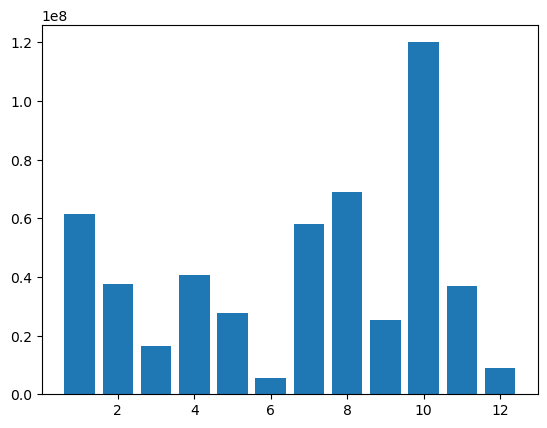

In [45]:
#group by month and bar chart 
mid_horror = data_mid[data_mid['main_genre'] == 'Horror']

horror_by_month = mid_horror.groupby('release_month')['total_profit'].median()
x = horror_by_month.index
y = horror_by_month.values

plt.bar(x, y);

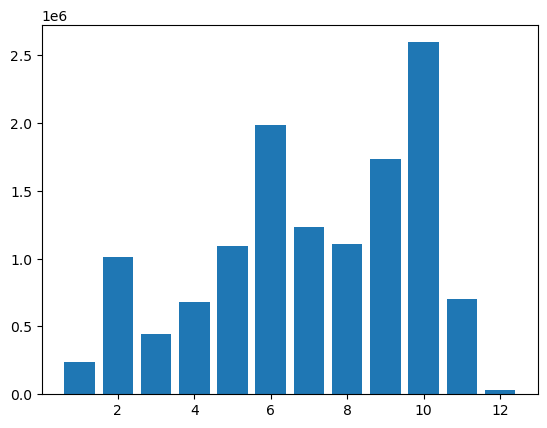

In [44]:
low_monthly_h = data_low.groupby('release_month')['total_profit'].median()
x = low_monthly.index
y = low_monthly.values

plt.bar(x, y);

## Linear Regression

In [72]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

horrors = movie_data[movie_data['main_genre'] == 'Horror']

X = horrors['production_budget'].values
y = horrors['ROI'].values
X = np.array(X).reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)



LinearRegression()

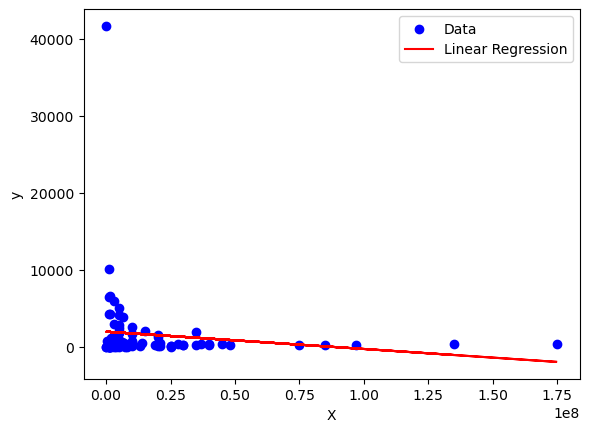

In [73]:
import matplotlib.pyplot as plt
plt.scatter(X, y, color='blue', label='Data')
plt.plot(X, model.predict(X), color='red', label='Linear Regression')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()


In [54]:
slope = model.coef_[0]
slope
intercept = model.intercept_
print(slope, intercept)

1.8087257502432896 55776595.41201301


In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

#data
X = X = horrors['production_budget'].values
y = y = horrors['ROI'].values
X = np.array(X).reshape(-1, 1)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an instance of the LinearRegression model
model = LinearRegression()

# Train the model using the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Calculate MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print("Mean Absolute Percentage Error (MAPE):", mape)




Root Mean Squared Error (RMSE): 1859.2394935284008
Mean Absolute Error (MAE): 1577.3427136048172
Mean Absolute Percentage Error (MAPE): 28952.148938798786


In [81]:
r2 = model.score(X_test, y_test)
print("R-squared:", r2)

R-squared: -0.14488400946049307
